---
**Step 1: Import Libraries & Check Versions**  

Before starting the project, we first import the core libraries and verify their versions.  
This helps ensure our environment is correctly set up and avoids compatibility issues later.  

- **fastai** → high-level deep learning framework (we’ll use it for classification & segmentation).  
- **torch** → PyTorch backend (fastai is built on top of this).  
- **opencv (cv2)** → computer vision utilities for image processing and visualization.  
- **numpy** → numerical operations and data handling.  
- **YOLO (Ultralytics)** → modern object detection framework (used to detect traffic lights).  

In [7]:
import fastai, torch, cv2, numpy as np
from fastai.vision.all import *
from ultralytics import YOLO

print("fastai:", fastai.__version__)
print("torch:", torch.__version__)
print("opencv:", cv2.__version__)
print("numpy:", np.__version__)


fastai: 2.7.17
torch: 2.4.1+cu121
opencv: 4.8.1
numpy: 1.26.4


---
**Step 2: Load and Preview a Road Image**

We’ll load a sample road scene that we’ll reuse for all three tasks in this project  
(**detection, classification, segmentation**).

---

**Why this step**  
Before running any model, it’s important to check:  
- the image file is in the notebook folder  
- the library can read the format (.webp / .jpg / .png)  
- the preview looks correct (orientation, size, visible traffic lights/roadway)  

---

**What the code does**  
- `PILImage.create("road.webp")` → loads the image into memory  
- `img.to_thumb(640)` → shows a smaller preview (640px wide)  

---


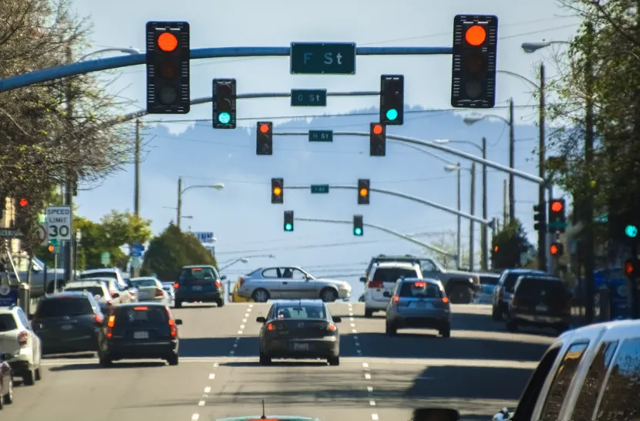

In [8]:
from fastai.vision.all import PILImage
img = PILImage.create("road.webp")
img.to_thumb(640)

---
**Step 3: Detect Traffic Lights (YOLOv8n)**

We now run a pre-trained YOLOv8 *nano* model on our road image to detect traffic lights.  
The nano model is the smallest version — fast and lightweight — perfect for a first test.

---

**Why this step**  
- YOLO is designed for *object detection* (find & draw boxes around things).  
- Starting with `yolov8n.pt` (nano) lets us test quickly before moving to larger models (s / m).  

---

**What the code does**  
- Loads YOLOv8n model from Ultralytics.  
- Runs inference (prediction) on our road image.  
- Displays the detected objects with bounding boxes.  

---


In [9]:
from ultralytics import YOLO

# load a pre-trained YOLOv8n (nano) model
yolo_model = YOLO("yolov8n.pt")

# run detection on our road image
results = yolo_model("road.webp", save=True, show=True)

# display results summary
for r in results:
    print(r.boxes.cls, r.boxes.conf)  # class IDs + confidence scores

100%|██████████| 6.25M/6.25M [00:00<00:00, 369MB/s]
/opt/conda/lib/python3.11/site-packages/ultralytics/nn/tasks.py:781: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt =

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()
The DISPLAY environment variable isn't set.

image 1/1 /home/jovyan/ML Projects /road.webp: 448x640 12 cars, 12 traffic lights, 47.4ms
Speed: 5.9ms preprocess, 47.4ms inference, 132.6ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict2
tensor([2., 2., 9., 2., 9., 2., 9., 9., 2., 2., 9., 9., 9., 2., 9., 9., 2., 2., 2., 9., 9., 9., 2., 2.], device='cuda:0') tensor([0.8948, 0.8941, 0.8819, 0.8808, 0.8711, 0.8616, 0.8572, 0.8297, 0.8241, 0.8202, 0.8189, 0.8167, 0.8167, 0.8056, 0.7887, 0.7867, 0.7574, 0.7184, 0.6975, 0.6665, 0.5011, 0.4418, 0.3121, 0.2740], device='cuda:0')


---
**Step 4: Run Object Detection (YOLOv8n)**

- Load a pre-trained YOLOv8 model.  
- Apply it to the road scene (`road.webp`).  
- YOLO outputs bounding boxes + confidence scores for objects (cars, traffic lights, etc.).  

---
**Why this matters:**  
This forms the foundation for later steps (classification + segmentation), since we first need to *locate* the traffic lights before checking their state.


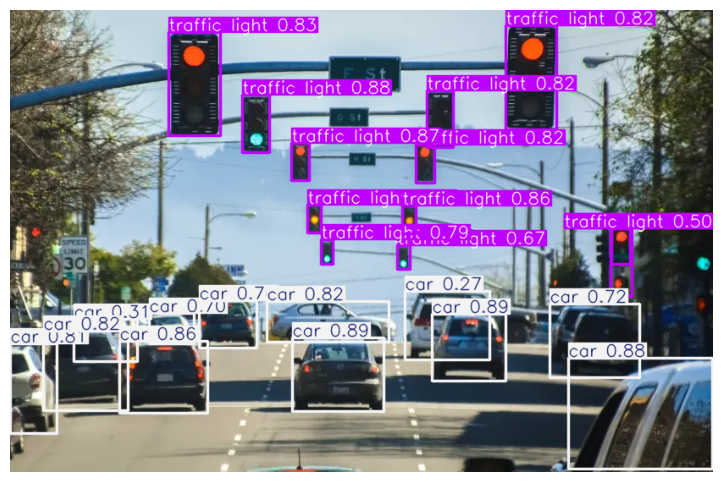

In [10]:
import matplotlib.pyplot as plt
import cv2
img_annot = results[0].plot() # Takes YOLO detection results from first image and draws bounding boxes and confidence labels   
plt.figure(figsize=(10,6))
plt.imshow(cv2.cvtColor(img_annot, cv2.COLOR_BGR2RGB)) # Fixes colours  
plt.axis('off')
plt.show()

---
**Step 5: Load and Display Saved YOLOv8 Predictions**  

After running YOLOv8, all detection results (bounding boxes + confidence scores) are automatically saved to the `runs/detect/` folder.  
Instead of just relying on live preview, we can reload the saved annotated image and display it directly in the notebook.  

---
**Why this step matters:**  
- Confirms that YOLO actually saved the detection results.  
- Lets us visually inspect the bounding boxes (cars, traffic lights, etc.) at any time.  
- Makes it easier to reuse the annotated results later without re-running the model.  

---
**What the code does:**  
- Uses `Path(results[0].save_dir)` → finds the folder where YOLO saved outputs.  
- Finds the first `.webp` image in that folder.  
- Opens it with PIL (`Image.open`) and displays the annotated result.  

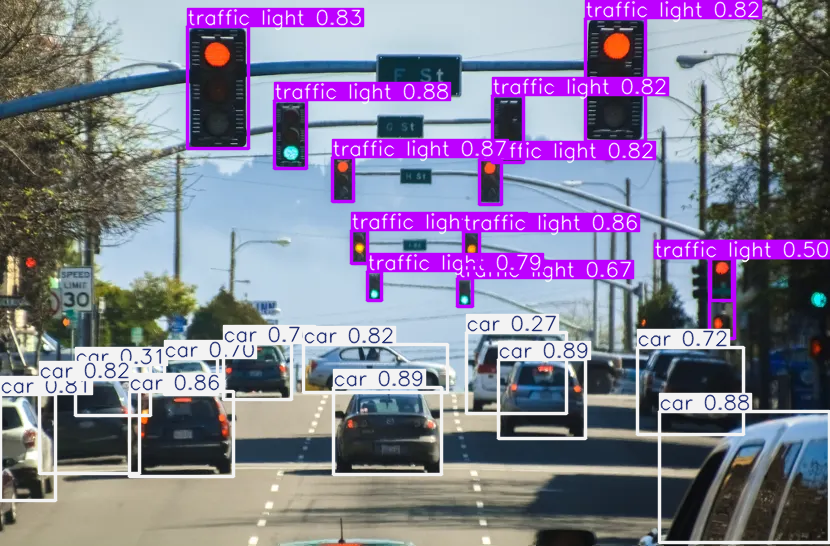

In [11]:
from PIL import Image
from pathlib import Path

save_dir = Path(results[0].save_dir) # 
display(Image.open(next(save_dir.glob("*.webp"))))

---
**Step 6: Isolate and Crop Traffic Lights**

Now that YOLO has detected all objects (cars, lights, etc.), we only want to **keep the traffic lights** for further analysis.  

**Why this step matters:**  
- The raw YOLO output includes many classes (cars, buses, signs, etc.).  
- Since our goal is to check traffic light colors, we must **filter by class ID = 9** (traffic lights in COCO dataset).  
- Cropping the bounding boxes allows us to extract just the traffic light regions from the image for classification.  

---

**What the code does:**  
1. `r = results[0]` → get YOLO’s first (and only) result object.  
2. `cls = boxes.cls.cpu().numpy()` → get predicted class IDs for each detection.  
3. `xyxy = boxes.xyxy.cpu().numpy()` → get bounding box coordinates (x1, y1, x2, y2).  
4. `keep = cls == 9` → select only detections with class ID = 9 (traffic lights).  
5. `tl_boxes = xyxy[keep]` → extract their bounding boxes.  
6. For each traffic light box:  
   - `orig.crop(...)` → crop the region of interest from the original road image.  
   - Save the crops in a list for later analysis.  
7. `len(crops)` → confirms how many traffic lights were extracted.  

In [12]:
import numpy as np
from PIL import Image

r = results[0]
names = r.names              # dict id->name
boxes = r.boxes              # Boxes object
cls   = boxes.cls.cpu().numpy().astype(int)
xyxy  = boxes.xyxy.cpu().numpy()  # (N,4)

# keep traffic lights only (class id 9 in COCO)
keep = cls == 9
tl_boxes = xyxy[keep]

# crop from the original image
orig = Image.open("road.webp").convert("RGB")
crops = []
for i,(x1,y1,x2,y2) in enumerate(tl_boxes.astype(int)):
    crop = orig.crop((x1,y1,x2,y2))
    crops.append(crop)

len(crops)

12

---
**Step 7: Visualise Cropped Traffic Lights**  

Now that we’ve isolated the traffic light regions from the road image, let’s display them to confirm the crops look correct.  

**Why this step matters:**  
- Ensures that YOLO’s bounding boxes actually captured traffic lights.  
- Gives a clear preview of each traffic light we’ll later classify into **red / yellow / green**.  
- Helps debug cases where bounding boxes are wrong or misaligned.  

---

**What the code does:**  
1. `cols = 6` → sets the number of columns in the grid display.  
2. `rows = int(np.ceil(len(crops)/cols))` → calculates rows automatically based on number of crops.  
3. `plt.figure(figsize=(cols*2, rows*2))` → scales the figure so crops aren’t too small.  
4. `for i, c in enumerate(crops, 1)` → loop through each cropped traffic light.  
   - `plt.subplot(rows, cols, i)` → place each crop in the grid.  
   - `plt.imshow(c)` → display the traffic light crop.  
   - `plt.axis('off')` → remove axis lines for a cleaner view.  
5. `plt.tight_layout()` → adjusts spacing to avoid overlap.  


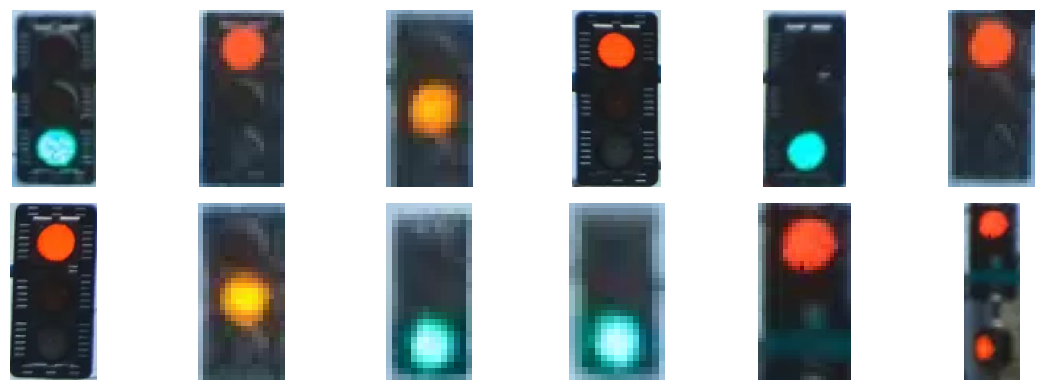

In [13]:
import matplotlib.pyplot as plt
cols = 6
rows = int(np.ceil(len(crops)/cols))
plt.figure(figsize=(cols*2, rows*2))
for i,c in enumerate(crops,1):
    plt.subplot(rows, cols, i)
    plt.imshow(c)
    plt.axis('off')
plt.tight_layout()

---
**Step 8: Classify Traffic Light Colors (Red, Yellow, Green)**

Now that we have cropped images of each traffic light, we need to determine their **color state** (red, yellow, or green).  
We use **HSV color space** (Hue, Saturation, Value) because it separates colors more effectively than raw RGB values.

---

**Why this step matters**
- Detecting *where* traffic lights are is not enough — we also need to know *what color they are*.  
- HSV makes it easier to apply thresholds for specific colors.  
- This step turns cropped traffic lights into meaningful labels: **red, yellow, green**.  

---

**What the code does**
1. Define a function `light_color_hsv`:
   - Crops the **center** of each light to reduce background influence.  
   - Converts the cropped image to **HSV color space**.  
   - Creates binary masks for **red, yellow, green** using HSV thresholds.  

2. Apply **color thresholds** (approximate HSV ranges):  
   - Red → Hue near 0° or >170°  
   - Yellow → Hue 20–35°  
   - Green → Hue 40–85°  

3. Score the pixels:
   - Counts how many pixels fall into each color mask.  
   - The color with the highest score is chosen as the prediction.  

4. Loop through all cropped lights:
   - Runs the classifier on each cropped traffic light.  
   - Appends the predicted label into a `labels` list.  

In [14]:
import cv2
import numpy as np

def light_color_hsv(pil_img):
    # center crop to reduce background influence
    w,h = pil_img.size
    cx, cy = w//2, h//2
    r = int(min(w,h)*0.35)
    crop = pil_img.crop((cx-r, cy-r, cx+r, cy+r))

    img = cv2.cvtColor(np.array(crop), cv2.COLOR_RGB2HSV)
    H,S,V = cv2.split(img)

    # masks (HSV ranges)
    red1   = ((H < 10) & (S>100) & (V>80))
    red2   = ((H >170) & (S>100) & (V>80))
    yellow = ((H>20) & (H<35) & (S>80) & (V>80))
    green  = ((H>40) & (H<85) & (S>60) & (V>60))

    score_red    = red1.sum() + red2.sum()
    score_yellow = yellow.sum()
    score_green  = green.sum()

    scores = {"red":score_red, "yellow":score_yellow, "green":score_green}
    label  = max(scores, key=scores.get)
    return label, scores

labels = []
for c in crops:
    label, _ = light_color_hsv(c)
    labels.append(label)

---
**Step 9: Overlay Color Labels on the Detections**

We’ve detected traffic lights (YOLO) and classified each one’s state (HSV).  
Now we’ll **draw those labels back on the road image** so the result is easy to read.

**Why this step matters**
- It ties everything together into one view: *detection + classification*.
- Colored labels (**red / yellow / green**) make it obvious which lights are active.
- We also handle color-channel order (OpenCV uses **BGR**; Matplotlib expects **RGB**).

**What the code does**
1. Start from YOLO’s annotated image (`results[0].plot()`), then copy it so we can draw on it.
2. For each traffic-light box + predicted label:
   - Pick a drawing color based on the label (`red`, `yellow`, `green`).
   - Draw a small **filled box** above the detection and put the text on top.
3. Convert the image from **BGR → RGB** for correct display in `matplotlib`.

> Note: `tl_boxes` (N×4) are the XYXY boxes for just the traffic lights,  
> and `labels` is the list of predicted colors for each crop (same order).

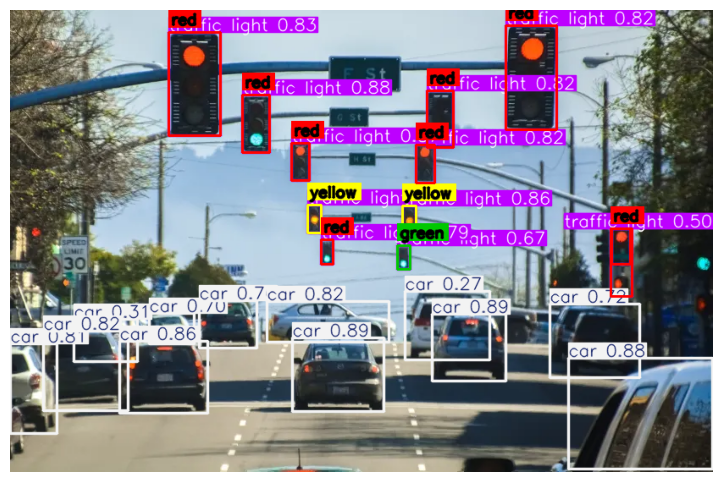

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Start from YOLO's annotated image (BGR) and copy so we can draw more
img = results[0].plot().copy()

# Color map for labels (OpenCV uses BGR)
color_map = {
    'red':    (0, 0, 255),
    'yellow': (0, 255, 255),
    'green':  (0, 200, 0),
}

font  = cv2.FONT_HERSHEY_SIMPLEX
scale = 0.6
thick = 2

# Draw a colored label for each traffic-light box
for (x1, y1, x2, y2), lbl in zip(tl_boxes.astype(int), labels):
    color = color_map.get(lbl, (255, 255, 255))  # white fallback

    # Put a small filled rectangle as label background (for readability)
    text = lbl
    (tw, th), _ = cv2.getTextSize(text, font, scale, thick)
    y_text = max(0, y1 - 6)
    cv2.rectangle(img, (x1, y_text - th - 6), (x1 + tw + 6, y_text), color, -1)

    # Draw the text in black on top of the colored background
    cv2.putText(img, text, (x1 + 3, y_text - 3), font, scale, (0, 0, 0), thick, cv2.LINE_AA)

    # (Optional) draw a box outline in the same color
    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

# Convert BGR -> RGB for correct display in matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

---
**Step 10: Road Segmentation with SegFormer**

Now we bring in a segmentation model (SegFormer) to identify the drivable road area in the image.  
This gives us a binary mask where each pixel is either *drivable* (road, parking) or *not drivable*.  
We’ll then overlay this mask in teal on top of the original road image.

##Why this step matters
- Adds **scene understanding**: beyond objects, we now know which pixels are road.  
- Provides a **navigation space** for vehicles, complementing detection results.  
- Overlaying the mask visually confirms what the model considers drivable.

**What the code does**
1. Load the SegFormer model (pre-trained on Cityscapes).  
2. Define drivable classes (`road`, `parking`) from the model’s label map.  
3. Create a helper function `make_drivable_mask` that returns a 0/1 mask for drivable pixels.  
4. Create an `overlay_mask` function to color the drivable pixels teal and blend them with the RGB image.  
5. Load your input image (`road.webp`), run the model, and generate the overlay visualization.  
6. Optionally save the result (e.g., `road_with_drivable.png`).  

**Notes**
- The overlay mask uses teal `(0,255,200)` with transparency for clarity.  
- The printout of `drivable mean` shows the fraction of pixels classified as drivable.

preprocessor_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

/opt/conda/lib/python3.11/site-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/14.9M [00:00<?, ?B/s]

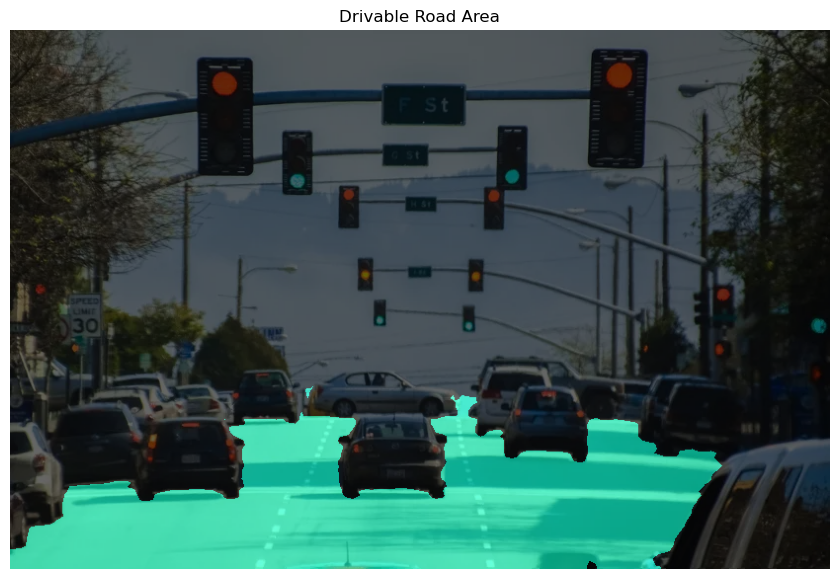

drivable mean (0..1): 0.16244538593936184


In [16]:
# --- Road segmentation (SegFormer) + overlay on road.webp ---

# 1) imports (install transformers/accelerate first if missing)
import numpy as np, cv2, torch
from PIL import Image
import matplotlib.pyplot as plt
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation

# 2) load SegFormer once
SEG_NAME  = "nvidia/segformer-b0-finetuned-cityscapes-1024-1024"
seg_proc  = SegformerImageProcessor.from_pretrained(SEG_NAME)
seg_model = SegformerForSemanticSegmentation.from_pretrained(SEG_NAME).eval()

# Cityscapes labels we consider "drivable"
id2label = seg_model.config.id2label
DRIVABLE_IDS = [i for i,lbl in id2label.items() if lbl in {"road","parking"}]

def make_drivable_mask(pil_img):
    """Return (H,W) uint8 mask: 1=drivable, 0=other."""
    inputs = seg_proc(images=pil_img, return_tensors="pt")
    with torch.no_grad():
        logits = seg_model(**inputs).logits              # [1,C,h/4,w/4]
    up = torch.nn.functional.interpolate(
        logits, size=pil_img.size[::-1], mode="bilinear", align_corners=False
    )                                                    # -> [1,C,H,W]
    pred = up.argmax(dim=1)[0].cpu().numpy()            # (H,W) class ids
    return np.isin(pred, DRIVABLE_IDS).astype(np.uint8) # (H,W) 0/1

def overlay_mask(rgb, mask01, color=(0,255,200), a_base=0.4, a_ov=0.6):
    """Blend teal where mask==1 onto an RGB uint8 image."""
    layer = np.zeros_like(rgb)
    layer[mask01==1] = color
    return cv2.addWeighted(rgb, a_base, layer, a_ov, 0)

# 3) run on your file road.webp
pil = Image.open("road.webp").convert("RGB")
rgb = np.array(pil)

mask01 = make_drivable_mask(pil)
out    = overlay_mask(rgb, mask01)  # <--- overlay result

plt.figure(figsize=(12,7)); plt.imshow(out); plt.axis('off'); plt.title('Drivable Road Area'); plt.show()
print("drivable mean (0..1):", mask01.mean())

# Optionally save
# Image.fromarray(out).save("road_with_drivable.png")


---
**Step 11: Draw YOLO Detections on the Image**

We use YOLO to detect objects (cars, traffic lights, etc.).  
This helper function `draw_yolo` draws bounding boxes and labels back onto the road image.

---
**Why this step matters**
- Turns YOLO’s raw detections into an **annotated image**.  
- Each box shows the **class label + confidence score**.  
- Helps visually confirm which detections YOLO made and with what certainty.  

---
**What the code does**
1. Copy the original image so we can draw on it.  
2. Extract YOLO’s bounding boxes (`xyxy`), class IDs, and confidence scores.  
3. Skip boxes below a chosen confidence threshold (`score_thresh`).  
4. Optionally filter classes (`classes_keep`).  
5. For each valid detection:
   - Draw a **white rectangle** around the object.  
   - Create a label string `"<class> <confidence>"`.  
   - Draw a filled black background box for readability.  
   - Overlay the label text on top.  
---
**Notes**
- Uses OpenCV (`cv2`) to handle drawing.  
- Labels include the class name from YOLO (`r.names[cls]`).  
- Confidence values are shown with 2 decimal places (e.g., 0.83).  


In [25]:
import cv2

def draw_yolo(rgb, results, score_thresh=0.25, classes_keep=None):
    """
    Draw YOLO bounding boxes + labels on an image.
    - rgb: numpy array (HxWx3)
    - results: YOLO predictions
    - score_thresh: minimum confidence to draw
    - classes_keep: list of class ids to keep (optional)
    """
    img = rgb.copy()
    r = results[0]
    if r.boxes is None:
        return img

    for box, cls, conf in zip(
        r.boxes.xyxy.cpu().numpy(),
        r.boxes.cls.cpu().numpy().astype(int),
        r.boxes.conf.cpu().numpy()
    ):
        if conf < score_thresh:
            continue
        if classes_keep is not None and cls not in classes_keep:
            continue

        x1, y1, x2, y2 = box.astype(int)
        label = f"{r.names[cls]} {conf:.2f}"

        # draw rectangle + label
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 255, 255), 2)
        (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
        cv2.rectangle(img, (x1, y1 - th - 6), (x1 + tw + 2, y1), (0, 0, 0), -1)
        cv2.putText(img, label, (x1, y1 - 4), cv2.FONT_HERSHEY_SIMPLEX,
                    0.6, (255, 255, 255), 2, cv2.LINE_AA)

    return img

---
**Step 12: Combine YOLO detections with Drivable Road Mask**

We now merge YOLO object detections (cars, traffic lights) with the drivable area predicted by SegFormer, so both are shown on the same road image.

---
**Why this step matters**
- It overlays **detection** (cars, lights) with **segmentation** (road mask).  
- The teal overlay clearly highlights safe driving areas.  
- Bounding boxes + labels ensure awareness of other traffic agents.  

---
**What the code does**
1. Load the YOLOv8 model (`yolov8n.pt`) for object detection.  
2. Read in the road image (`road.webp`) and convert it to RGB.  
3. Generate a drivable mask with `make_drivable_mask`.  
4. Overlay the mask onto the road image using `overlay_mask`.  
5. Define a detection confidence threshold (`BOX_THRES = 0.25`).  
6. Run YOLO detections on the same image to detect cars and traffic lights.  
7. Draw bounding boxes and labels on top using the `draw_yolo` helper.  
8. Show the final combined visualization with **cars + traffic lights + drivable road area**.

---
**Notes**
- `YOLO_CLASSES = [2, 9]` restricts detection to cars (class 2) and traffic lights (class 9).  
- The drivable road mask uses teal `(0,255,200)` with transparency for clarity.  
- The confidence threshold ensures only strong detections are kept.  


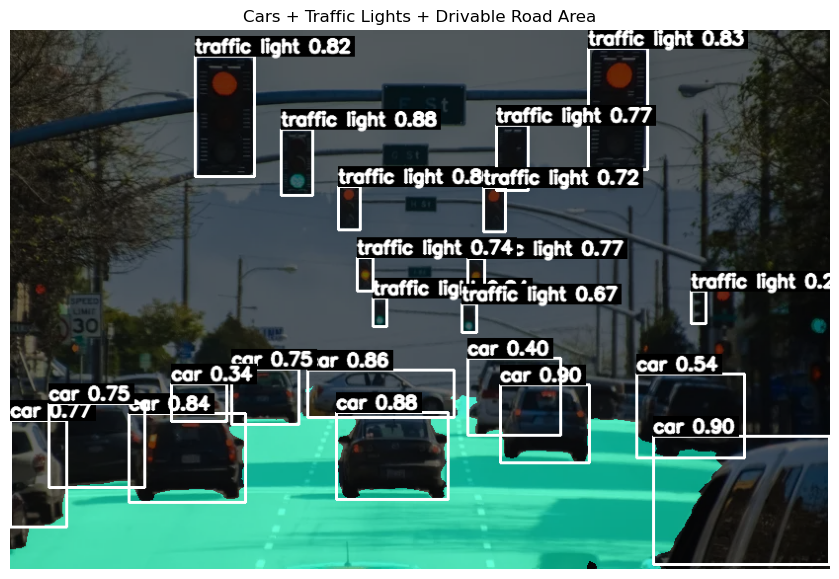

In [26]:
from ultralytics import YOLO

# Load YOLOv8 model (cars + traffic lights etc.)
detector = YOLO("yolov8n.pt") 
# 1. Load your image
pil = Image.open("road.webp").convert("RGB")
rgb = np.array(pil)

# 2. Add drivable road mask
mask01 = make_drivable_mask(pil)
rgb    = overlay_mask(rgb, mask01)

BOX_THRES = 0.25        # confidence threshold
YOLO_CLASSES = [2, 9] 

# 3. Run YOLO detections + your TL classifier on this rgb
results = detector.predict(rgb, verbose=False)
final   = draw_yolo(rgb, results, score_thresh=BOX_THRES, classes_keep=YOLO_CLASSES)

# 4. Show combined output
plt.figure(figsize=(12,7))
plt.imshow(final); plt.axis('off')
plt.title("Cars + Traffic Lights + Drivable Road Area")
plt.show()
